<a href="https://colab.research.google.com/github/Maryam-Mostafa/ContractNLI-classification/blob/master/NLI_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topics in Data Analytics S23**
- a system is given a set of hypotheses and a contract, and it is
asked to classify whether each hypothesis is entailed by, contradicting to or not
mentioned by (neutral to) the contract as well as identifying evidence for the
decision as spans in the contract.
- The complete description of this dataset could
be found here: https://stanfordnlp.github.io/contract-nli/
-  More SOTA approaches on this task can be found here: https://paperswithcode.com/task/naturallanguage-inference

## Import Liberaries

In [ ]:
!pip install transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
import zipfile
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import torch
from torch.utils.data import Dataset, Dataset
from torch.utils.data import DataLoader
from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding,AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


##Q1: Prepare Dataset
* check the statistics of the dataset.
* design how to generate new files from the raw dataset to support your NLI task training, validation and testing.
* summarize your approach (how you prepare the train/test/validation set).



### Solution:
1. load the dataset from github

In [ ]:
!git clone https://github.com/stanfordnlp/contract-nli.git

Cloning into 'contract-nli'...
remote: Enumerating objects: 42, done.
remote: Total 42 (delta 0), reused 0 (delta 0), pack-reused 42
Receiving objects: 100% (42/42), 62.49 MiB | 17.70 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
zip_file_path = '/content/contract-nli/resources/contract-nli.zip'
extracted_dir = 'content/contract-nli/'

if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)


2. Create a function that opens the json files for train/dev/test and load it then convert them into a csv format for each to use them easily and extract the needed information.

In [ ]:
def create_df(json_path):
  #read json file
  with open(json_path, 'r') as json_file:
        data = json.load(json_file)

  # Extract required information from the JSON data
  documents = data["documents"]
  document_info = []

  for document in documents:
      doc_text = document["text"]
      annotations = document["annotation_sets"][0]["annotations"]
      for key, value in annotations.items():
          hypothesis = data['labels'][key]['hypothesis']
          choice = value["choice"]
          document_info.append([doc_text, hypothesis, choice])

  # Create a DataFrame
  df = pd.DataFrame(document_info, columns=["Document_Text", "Hypothesis", "Label"])
  return df

3. create the 3 dataframe for train, dev, test

In [ ]:
def to_csv(df,name):
  df.to_csv(f'{name}_df.csv', index=False, header=True)

In [ ]:
train_df = create_df('/content/content/contract-nli/contract-nli/train.json')
dev_df = create_df('/content/content/contract-nli/contract-nli/dev.json')
test_df = create_df('/content/content/contract-nli/contract-nli/test.json')

In [ ]:
to_csv(train_df,"train")
to_csv(dev_df,'dev')
to_csv(test_df,'test')

4. EDA for train dataset:

  a. overview of the dataset

In [ ]:
train_df.head()

,Document_Text,Hypothesis,Label
0,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment
4,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned


In [ ]:
train_df.describe()

,Document_Text,Hypothesis,Label
count,7191,7191,7191
unique,423,17,3
top,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,Entailment
freq,17,423,3530


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7191 entries, 0 to 7190
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Document_Text  7191 non-null   object
 1   Hypothesis     7191 non-null   object
 2   Label          7191 non-null   object
dtypes: object(3)
memory usage: 168.7+ KB


***From the overview of the train dataset we can see the following:***
* The length of the train set is 7191 record.
* There are no null values in the dataset.
* The **"Document_Text"** column seems to have some repeated text, with 423 unique texts, but the most frequent text is repeated 17 times. This could indicate that the data might have multiple instances of the same document text, possibly with different annotations.

* The **"Label"** column has three unique choices, and the majority of the annotations are labeled as **"Entailment"**.



  b. Distribution of Label:

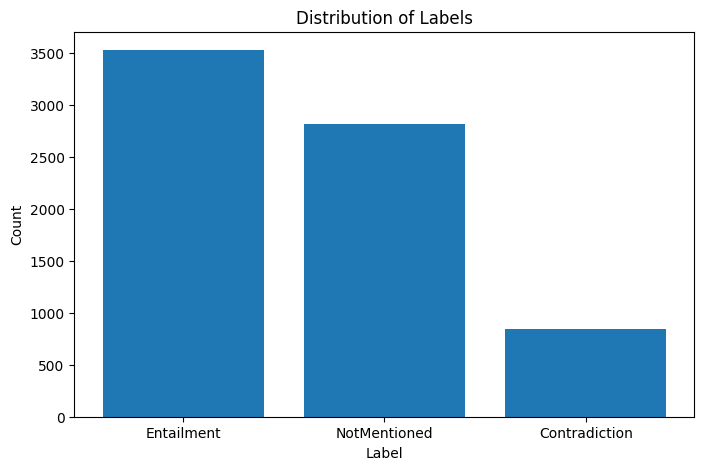

In [ ]:
# Count the occurrences of each choice
choice_counts = train_df["Label"].value_counts()

# Plot the distribution of choices
plt.figure(figsize=(8, 5))
plt.bar(choice_counts.index, choice_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

* The label distribution in the "Choice" column is imbalanced, with a significant number of instances belonging to "Entailment" compared to "Contradiction." Imbalanced class distributions can impact the performance of the models it might affect the model's ability to learn and generalize patterns for "Contradiction" class.

* To handle this issue we can use class-weighted approaches during model training and choose different metrics like precision, recall, F1-score, or area under the Receiver Operating Characteristic (ROC) curve instead of accuracy.

  c. Word cloud for document text:

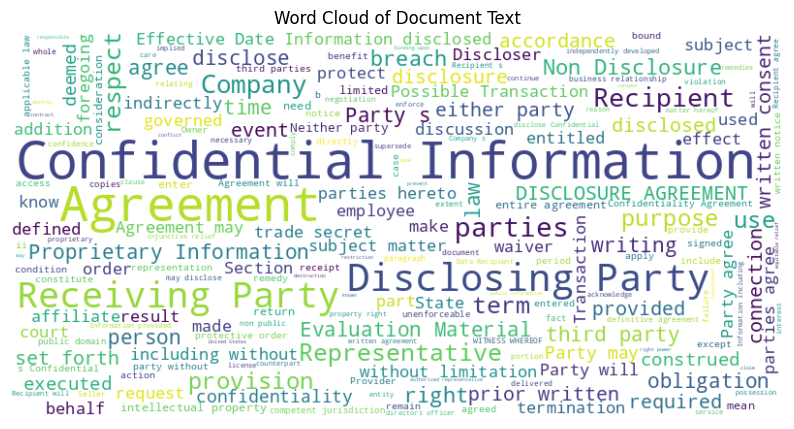

In [ ]:
# Concatenate all the document text into a single string
all_text = " ".join(train_df["Document_Text"])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Document Text")
plt.show()


*  We can colclude that `Confidential information` is the most repeated word in the documents.





d. Hypothesis Analysis

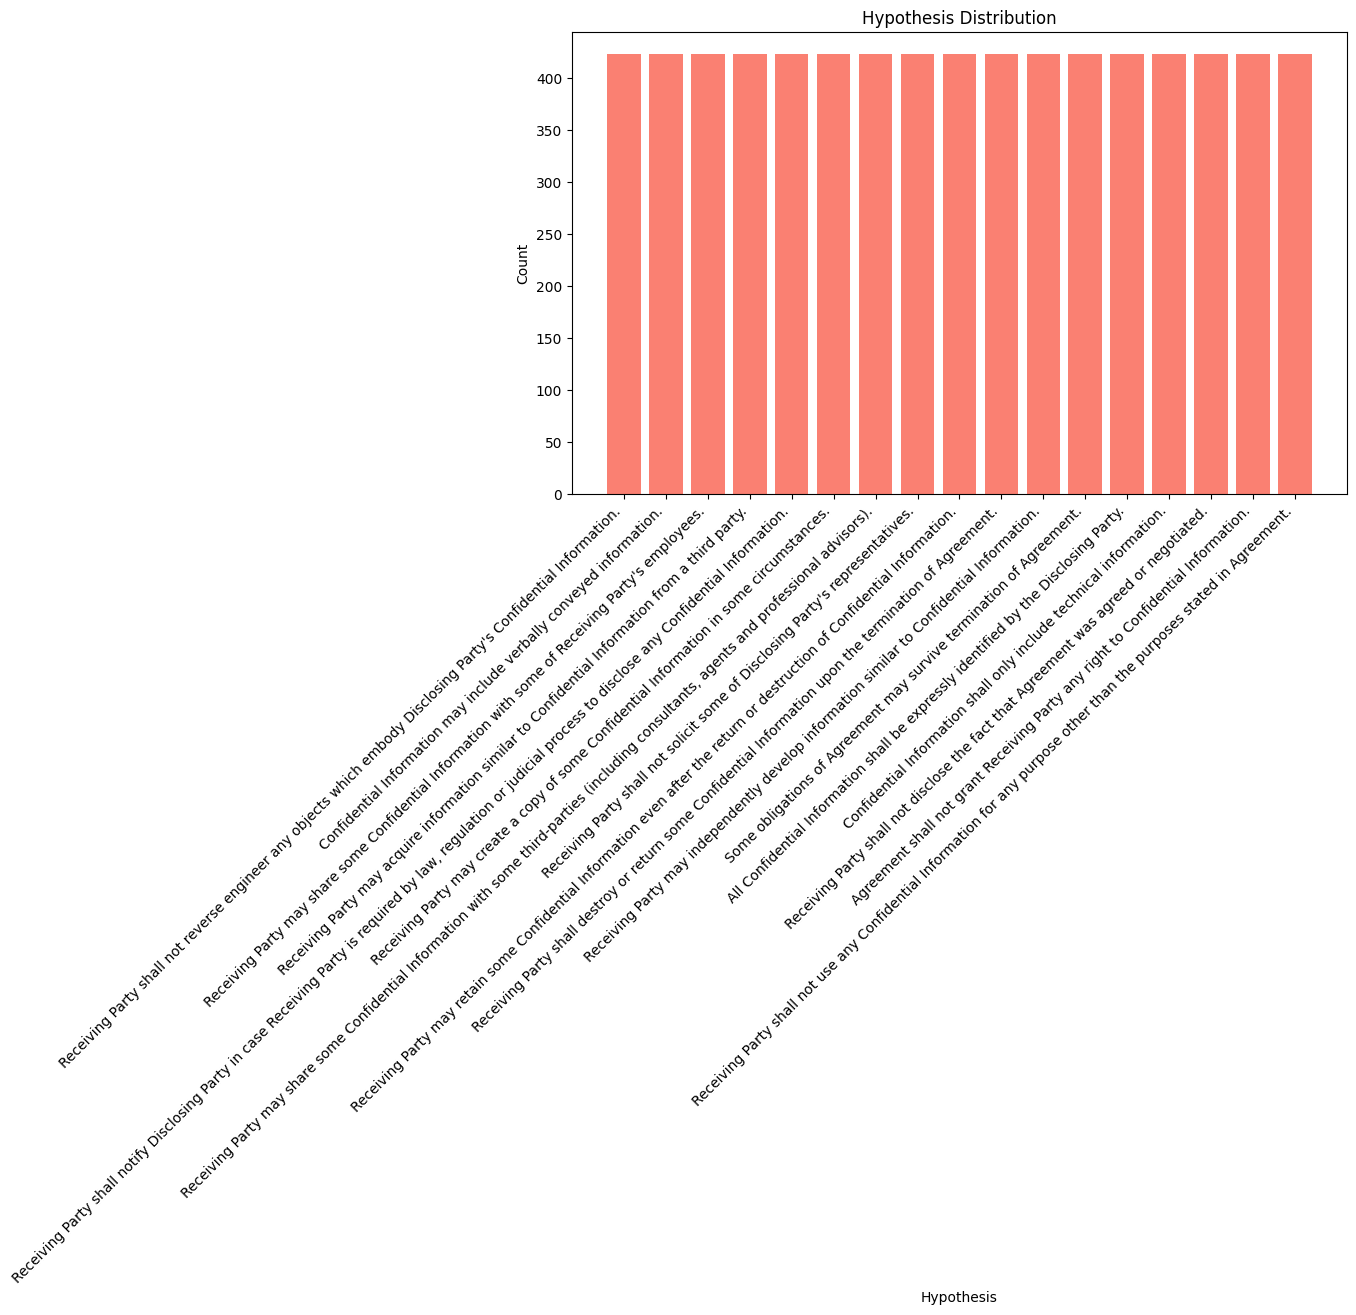

In [ ]:
hypothesis_counts = train_df["Hypothesis"].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(hypothesis_counts.index, hypothesis_counts.values, color="salmon")
plt.xlabel("Hypothesis")
plt.ylabel("Count")
plt.title("Hypothesis Distribution")
plt.xticks(rotation=45, ha="right")
plt.show()

* we see that all 17 hypothesis are equally distrubuted.

e. Document Text Length Analysis

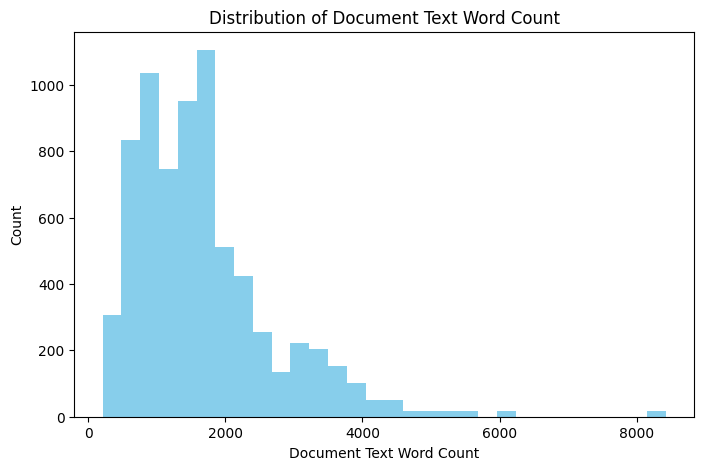

In [ ]:
# Calculate the word count of the documents
train_df["Document Text Word Count"] = train_df["Document_Text"].apply(lambda x: len(x.split()))

# Plot the histogram of word counts
plt.figure(figsize=(8, 5))
plt.hist(train_df["Document Text Word Count"], bins=30, color="skyblue")
plt.xlabel("Document Text Word Count")
plt.ylabel("Count")
plt.title("Distribution of Document Text Word Count")
plt.show()


The graph shows Left-Skewed Document Text Length Distribution

* It means that the majority of instances have longer document text lengths, while a few instances have much shorter document texts.
The tail of the distribution extends towards the left, indicating the presence of a few outliers with shorter text lengths.
Data Imbalance

* This can lead to data imbalance, where longer document text lengths are overrepresented, while shorter texts are underrepresented.
This imbalance may impact the performance of the models, particularly if they are sensitive to the distribution of data.

Descriptive Statistics for Document Text Word Count:
Mean: 1673.6312056737588
Median: 1504.0
Mode: 1014
Minimum: 211
Maximum: 8428
Standard Deviation: 1029.0160362092142


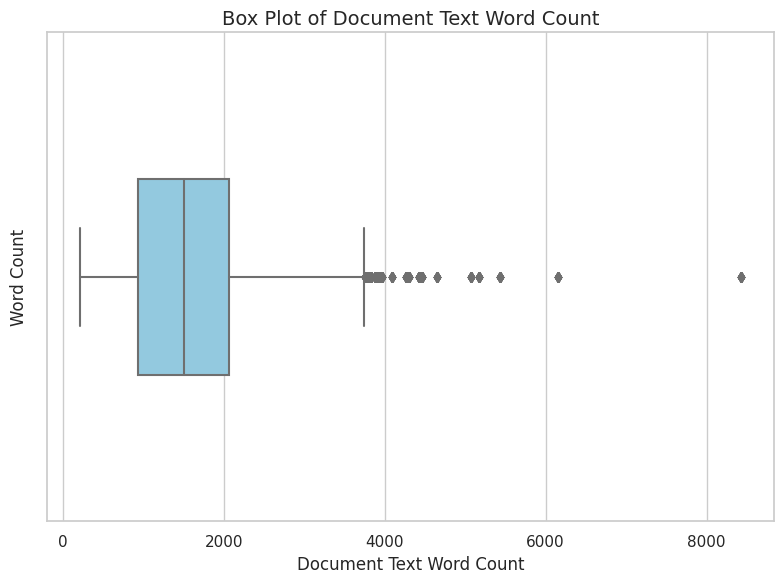

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already loaded your dataset into the variable "train_df"

# Calculate the word count of the documents
train_df["Document Text Word Count"] = train_df["Document_Text"].apply(lambda x: len(x.split()))

# Calculate descriptive statistics
mean_word_count = train_df["Document Text Word Count"].mean()
median_word_count = train_df["Document Text Word Count"].median()
mode_word_count = train_df["Document Text Word Count"].mode().iloc[0]
min_word_count = train_df["Document Text Word Count"].min()
max_word_count = train_df["Document Text Word Count"].max()
std_word_count = train_df["Document Text Word Count"].std()

# Print descriptive statistics
print("Descriptive Statistics for Document Text Word Count:")
print(f"Mean: {mean_word_count}")
print(f"Median: {median_word_count}")
print(f"Mode: {mode_word_count}")
print(f"Minimum: {min_word_count}")
print(f"Maximum: {max_word_count}")
print(f"Standard Deviation: {std_word_count}")

# Set up Seaborn style
sns.set(style="whitegrid")

# Plot the box plot with enhanced aesthetics
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_df["Document Text Word Count"], color="skyblue", width=0.4)
plt.xlabel("Document Text Word Count", fontsize=12)
plt.ylabel("Word Count", fontsize=12)
plt.title("Box Plot of Document Text Word Count", fontsize=14)
plt.tight_layout()
plt.show()


1. Mean (1673.63):
   - The average word count across all documents in the dataset is approximately 1673 words. This value represents the central tendency of the text length distribution.

2. Median (1504.0):
   - The median word count is 1504 words, which is slightly lower than the mean. The median serves as a robust measure of central tendency, indicating that the data might be slightly positively skewed.

3. Mode (1014):
   - The mode represents the most frequent word count, and it is 1014 words. This indicates that there is a significant number of documents with similar lengths around this value.

4. Minimum (211) and Maximum (8428):
   - The shortest document contains 211 words, while the longest one contains 8428 words. This wide range shows considerable variability in text lengths.

5. Standard Deviation (1029.02):
   - The standard deviation of approximately 1029.02 quantifies the spread or dispersion of the word counts around the mean. A higher standard deviation suggests significant variability in text lengths.

6. Distribution and Outliers:
   - The box plot reveals the presence of outliers in the data, represented by data points beyond the upper whisker. These outliers correspond to very long documents with word counts significantly higher than the majority of documents.

7. Handling Outliers:
   - Outliers can affect model training and performance, as they can lead to biased estimates and reduced generalization. Careful consideration and handling of outliers in the data preprocessing stage are crucial for improving model performance.

8. Data Imbalance:
   - The significant difference between the mean and median might indicate an imbalance in text lengths. Outliers contribute to this imbalance and may affect the model's ability to generalize.

9. Model Performance:
   - Addressing the presence of outliers and data imbalance is essential for building robust models that can handle varying text lengths effectively.



### ***Now I will gather all the EDA in one function to apply it with the dev and test sets***

In [ ]:
def EDA(df):
  #1. overview of the data
  print(f'sample of data\n:{df.head()}\n=================================================================')
  print(f'Description of data\n:{df.describe()}\n=================================================================')
  print(f'Information about data\n:{df.info()}\n=================================================================')

  #2. distribution of choices
  print('                  distribution of Label         \n=================================================================\n')
  choice_counts = df["Label"].value_counts()
  plt.figure(figsize=(8, 5))
  plt.bar(choice_counts.index, choice_counts.values)
  plt.xlabel("Label")
  plt.ylabel("Count")
  plt.title("Distribution of Labels")
  plt.show()

  #3. Word analysis (word cloud)
  print('\n=================================================================\n                  Word analysis                    \n=================================================================\n')
  all_text = " ".join(df["Document_Text"])
  wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title("Word Cloud of Document Text")
  plt.show()

  #5. Document Text Length Analysis
  print('\n=================================================================\n         Document Text Length Analysis               \n=================================================================\n')
  train_df["Document Text Word Count"] = train_df["Document_Text"].apply(lambda x: len(x.split()))
  plt.figure(figsize=(8, 5))
  plt.hist(train_df["Document Text Word Count"], bins=30, color="skyblue")
  plt.xlabel("Document Text Word Count")
  plt.ylabel("Count")
  plt.title("Distribution of Document Text Word Count")
  plt.show()

  # Calculate descriptive statistics
  mean_word_count = train_df["Document Text Word Count"].mean()
  median_word_count = train_df["Document Text Word Count"].median()
  mode_word_count = train_df["Document Text Word Count"].mode().iloc[0]
  min_word_count = train_df["Document Text Word Count"].min()
  max_word_count = train_df["Document Text Word Count"].max()
  std_word_count = train_df["Document Text Word Count"].std()

  # Print descriptive statistics
  print("Descriptive Statistics for Document Text Word Count:")
  print(f"Mean: {mean_word_count}")
  print(f"Median: {median_word_count}")
  print(f"Mode: {mode_word_count}")
  print(f"Minimum: {min_word_count}")
  print(f"Maximum: {max_word_count}")
  print(f"Standard Deviation: {std_word_count}")

  # Set up Seaborn style
  sns.set(style="whitegrid")

  # Plot the box plot with enhanced aesthetics
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=train_df["Document Text Word Count"], color="skyblue", width=0.4)
  plt.xlabel("Document Text Word Count", fontsize=12)
  plt.ylabel("Word Count", fontsize=12)
  plt.title("Box Plot of Document Text Word Count", fontsize=14)
  plt.tight_layout()
  plt.show()




sample of data
:                                       Document_Text  \
0  OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...   
1  OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...   
2  OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...   
3  OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...   
4  OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...   

                                          Hypothesis          Label  
0  Receiving Party shall not reverse engineer any...     Entailment  
1  Receiving Party shall destroy or return some C...     Entailment  
2  Agreement shall not grant Receiving Party any ...     Entailment  
3  Receiving Party shall not disclose the fact th...     Entailment  
4  Confidential Information shall only include te...  Contradiction  
Description of data
:                                            Document_Text  \
count                                                1037   
unique                                                 61   
top     OISAIR PROJECT\

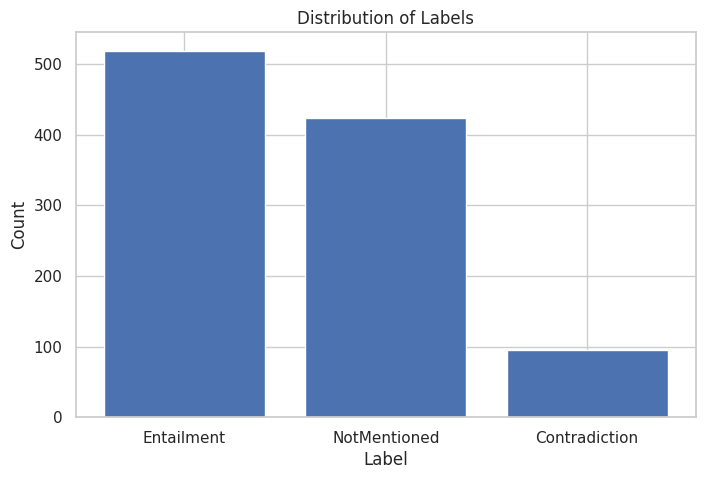


                  Word analysis                    



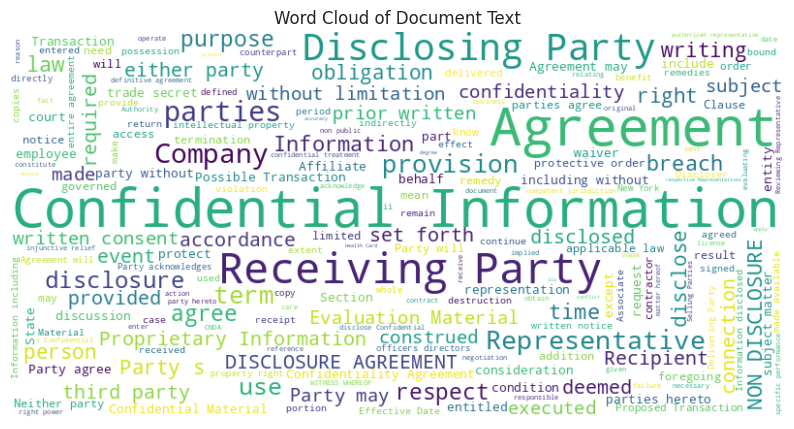


         Document Text Length Analysis               



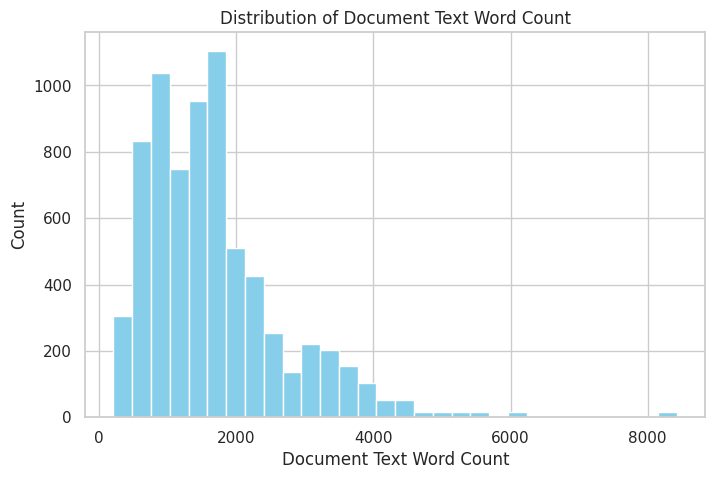

Descriptive Statistics for Document Text Word Count:
Mean: 1673.6312056737588
Median: 1504.0
Mode: 1014
Minimum: 211
Maximum: 8428
Standard Deviation: 1029.0160362092142


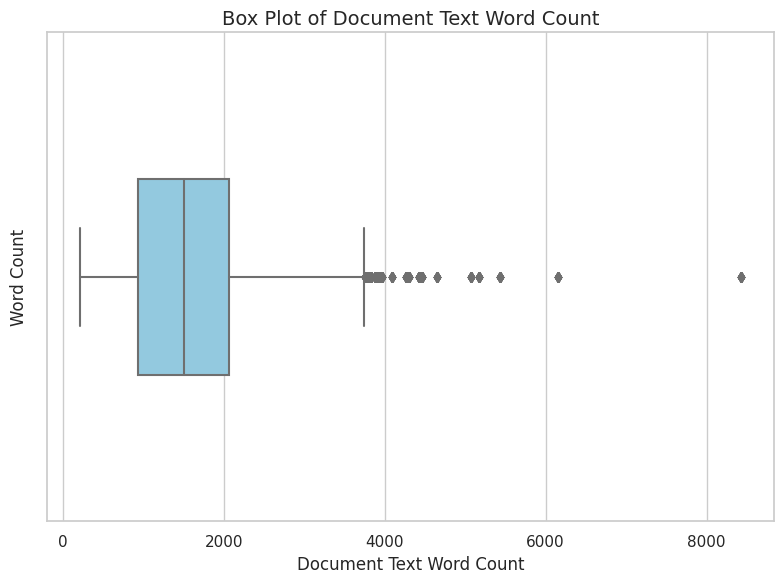

In [ ]:
EDA(dev_df)

sample of data
:                                       Document_Text  \
0  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
1  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
2  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
3  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
4  NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   

                                          Hypothesis          Label  
0  Receiving Party shall not reverse engineer any...   NotMentioned  
1  Receiving Party shall destroy or return some C...     Entailment  
2  Agreement shall not grant Receiving Party any ...     Entailment  
3  Receiving Party shall not disclose the fact th...   NotMentioned  
4  Confidential Information shall only include te...  Contradiction  
Description of data
:                                            Document_Text  \
count                                                2091   
unique                                                122   
top     DEPARTMENT OF H

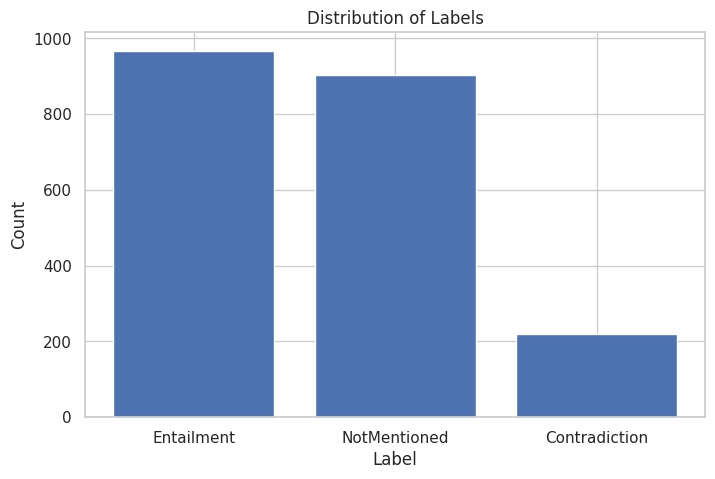


                  Word analysis                    



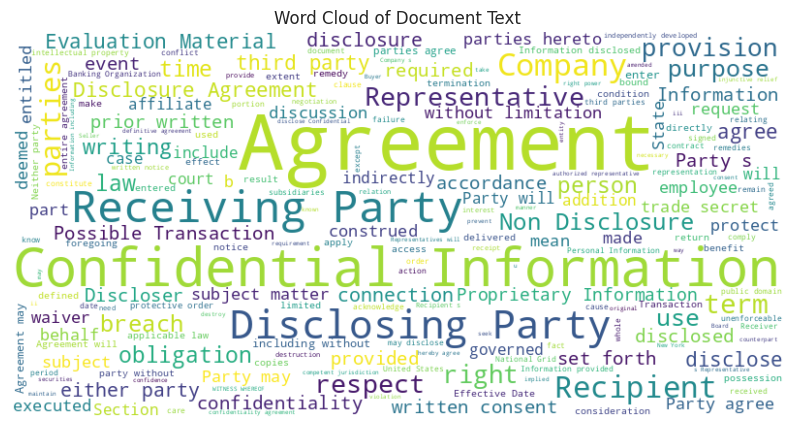


         Document Text Length Analysis               



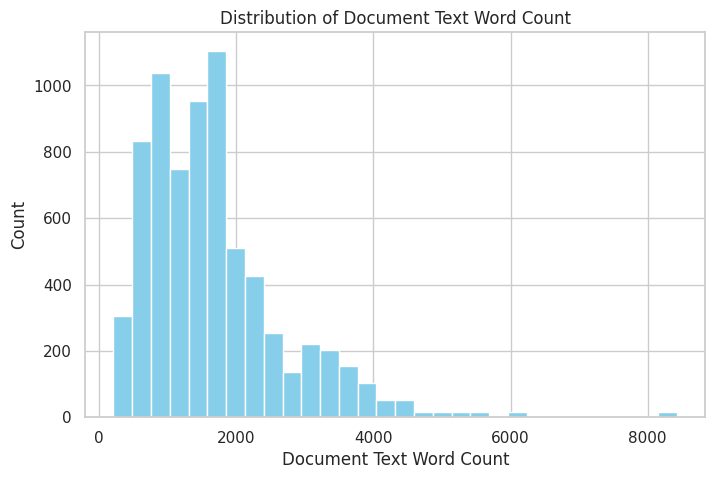

Descriptive Statistics for Document Text Word Count:
Mean: 1673.6312056737588
Median: 1504.0
Mode: 1014
Minimum: 211
Maximum: 8428
Standard Deviation: 1029.0160362092142


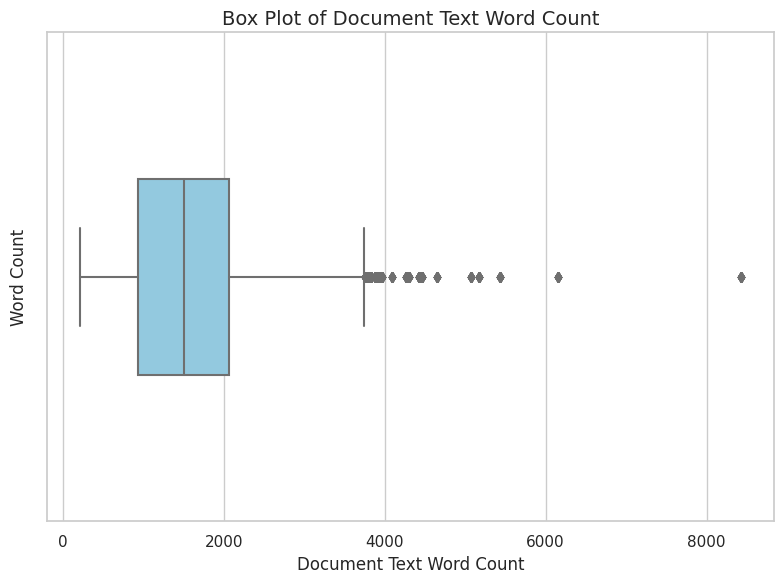

In [ ]:
EDA(test_df)

So let's sammarize what I have done so far:
1. I accessed the dataset form github.
2. unzipped it and extracted the folders.
3. The files format was json so I accessed them and picked the featuered I want.
4. Added them to a dataframe, and apply this to all 3 files train, dev and test.
5. Save the dataframes to csv's.
5. Then I investigate the dataset by applying differenet EDA on it and commented on the useful insights from each one of them.


##Q2: Perform NLI using two transformer based approaches.
* SOTA approaches from paperwithcode.
* Hugging face implementation pre-trained model DeBerta (https://huggingface.co/docs/transformers/model_doc/deberta). I need to fine tune the model.
* Report the performance of two models on the dataset.

Sol:
I aimed to use two pretrained models (**DeBERTa-base**) and (**DistilBERT**), however DeBERTa was too large and the memory crashed multiple times so I was trying to solve this problem with many approches but unfortunetly I couldn't reach to a result.


### Now let's prepare data for the models

## 1. DeBERTa

In [ ]:
# Load the Deberta model and tokenizer
model_name = 'microsoft/deberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
class ContractNLIDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
def tokenize_data(df):
  return tokenizer(text=df['Document_Text'].tolist(), text_pair=df['Hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

In [ ]:
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train_df['Label'].tolist()]
val_labels = [label_mapping[label] for label in dev_df['Label'].tolist()]
test_labels = [label_mapping[label] for label in test_df['Label'].tolist()]

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(dev_df)
test_encodings = tokenize_data(test_df)

In [ ]:
train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(val_encodings, val_labels)
test_dataset  = ContractNLIDataset(test_encodings, test_labels)

This is a customized metrics so accuracy won't be enough for judging the model

In [ ]:
def custom_compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    precision_weighted = precision_score(labels, preds, average='weighted')
    recall_weighted = recall_score(labels, preds, average='weighted')
    f1_weighted = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision_weighted,
        'recall': recall_weighted,
        'f1_score': f1_weighted,
    }


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    evaluation_strategy='epoch'
    )

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics = custom_compute_metrics,
    )

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.982400,0.934590,0.500482,0.250482,0.500482,0.333869
2,0.962000,0.931674,0.500482,0.250482,0.500482,0.333869
3,0.965100,0.931437,0.500482,0.250482,0.500482,0.333869


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=5394, training_loss=0.9783091985343959, metrics={'train_runtime': 4133.6512, 'train_samples_per_second': 5.219, 'train_steps_per_second': 1.305, 'total_flos': 6614280971596800.0, 'train_loss': 0.9783091985343959, 'epoch': 3.0})

In [ ]:
# Save the trained model and tokenizer
trainer.save_model("./saved_model_deBERTa")
import zipfile

# Zip the saved model directory
saved_model_dir = "./saved_model_deBERTa"
zip_filename = "saved_model1.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(saved_model_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, saved_model_dir))

### Evaluate the model on the validation set

In [ ]:
# Evaluate the model on the validation set
eval_result_model = trainer.evaluate(eval_dataset=valid_dataset)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
eval_result_model

{'eval_loss': 0.9314369559288025,
 'eval_accuracy': 0.5004821600771456,
 'eval_precision': 0.2504823925554856,
 'eval_recall': 0.5004821600771456,
 'eval_f1_score': 0.3338692044730573,
 'eval_runtime': 56.4876,
 'eval_samples_per_second': 18.358,
 'eval_steps_per_second': 4.603,
 'epoch': 3.0}

In [ ]:
print(f"Validation accuracy: {eval_result_model['eval_accuracy']:.4f}\nprecision: {eval_result_model['eval_precision']:.4f}\nrecall: {eval_result_model['eval_recall']:.4f}\nF1-score: {eval_result_model['eval_f1_score']:.4f}")

Validation accuracy: 0.5005
precision: 0.2505
recall: 0.5005
F1-score: 0.3339


### Evaluate the model on the test set

In [ ]:
# Evaluate the model on the validation set
test_dataset_result_model = trainer.evaluate(test_dataset)
test_dataset_result_model

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.9602281451225281,
 'eval_accuracy': 0.46293639406982307,
 'eval_precision': 0.2143101049543705,
 'eval_recall': 0.46293639406982307,
 'eval_f1_score': 0.29298622390296747,
 'eval_runtime': 118.3529,
 'eval_samples_per_second': 17.668,
 'eval_steps_per_second': 4.419,
 'epoch': 3.0}

In [ ]:
print(f"Validation accuracy: {test_dataset_result_model['eval_accuracy']:.4f}\nprecision: {test_dataset_result_model['eval_precision']:.4f}\nrecall: {test_dataset_result_model['eval_recall']:.4f}\nF1-score: {test_dataset_result_model['eval_f1_score']:.4f}")

Validation accuracy: 0.4629
precision: 0.2143
recall: 0.4629
F1-score: 0.2930


## 2.  DistilBERT
The DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [ ]:
# Load the distilbert tokenizer
model_name2 = 'distilbert-base-uncased'
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)

In [ ]:
def tokenize_data2(df):
  return tokenizer2(text=df['Document_Text'].tolist(), text_pair=df['Hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

In [ ]:
class ContractNLIDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train_df['Label'].tolist()]
val_labels = [label_mapping[label] for label in dev_df['Label'].tolist()]
test_labels = [label_mapping[label] for label in test_df['Label'].tolist()]

train_encodings = tokenize_data2(train_df)
val_encodings = tokenize_data2(dev_df)
test_encodings = tokenize_data2(test_df)

train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(val_encodings, val_labels)
test_dataset  = ContractNLIDataset(test_encodings, test_labels)

In [ ]:
def custom_compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    precision_weighted = precision_score(labels, preds, average='weighted')
    recall_weighted = recall_score(labels, preds, average='weighted')
    f1_weighted = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
    }


In [ ]:
model2 = AutoModelForSequenceClassification.from_pretrained(model_name2, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results2',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs2',
    evaluation_strategy='epoch'
    )

trainer2 = Trainer(
    model=model2,
    args=training_args,
    tokenizer=tokenizer2,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics = custom_compute_metrics,
    )

In [ ]:
trainer2.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted
1,0.794700,0.693389,0.682739,0.691204,0.682739,0.685844
2,0.663000,0.696230,0.691418,0.695856,0.691418,0.691817


TrainOutput(global_step=1798, training_loss=0.6985710067664158, metrics={'train_runtime': 5225.1569, 'train_samples_per_second': 2.752, 'train_steps_per_second': 0.344, 'total_flos': 238147512880896.0, 'train_loss': 0.6985710067664158, 'epoch': 2.0})

In [ ]:
# Save the trained model and tokenizer
trainer2.save_model("./saved_model_distilBert")
import zipfile

# Zip the saved model directory
saved_model_dir = "./saved_model_distilBert"
zip_filename = "saved_model2.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(saved_model_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, saved_model_dir))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluate the model on the validation set
eval_result_model2 = trainer2.evaluate(eval_dataset=valid_dataset)

In [ ]:
eval_result_model2

{'eval_loss': 0.6962303519248962,
 'eval_accuracy': 0.6914175506268081,
 'eval_precision_weighted': 0.6958560965219938,
 'eval_recall_weighted': 0.6914175506268081,
 'eval_f1_weighted': 0.6918166878576125,
 'eval_runtime': 122.1091,
 'eval_samples_per_second': 8.492,
 'eval_steps_per_second': 1.065,
 'epoch': 2.0}

In [ ]:
print(f"Validation accuracy: {eval_result_model2['eval_accuracy']:.4f}\nprecision: {eval_result_model2['eval_precision_weighted']:.4f}\nrecall: {eval_result_model2['eval_recall_weighted']:.4f}\nF1-score: {eval_result_model2['eval_f1_weighted']:.4f}")

Validation accuracy: 0.6914
precision: 0.6959
recall: 0.6914
F1-score: 0.6918


##Q3: Analyze the performance of the two models and perform error analysis
* Explain how you design the methodology to perform error analysis with a goal of understanding.
* What are the potential reasons behind the errors.



### **The methodologies of error analysis I chose:**
1. **Identify incorrect predictions**:
  - compare predicted and actual labels.
  - see the documents that models fails to classify.

2. **Classification Report**:
   - The classification report provides precision, recall, F1-score, and support for each class (NotMentioned, Entailment, Contradiction).
   - This report gives a detailed overview of the model's performance for each class.

3. **Confusion Matrix Visualization**:
   - Calculate the confusion matrix using the true labels and predicted labels.
   - Plot the confusion matrix as a heatmap to visualize the distribution of correct and incorrect predictions for each class.
   - The heatmap provides insights into the model's performance and misclassifications.

4. **Most Common Misclassified Class**:
   - Find the indices of misclassified samples by comparing true labels with predicted labels.
   - Extract the class labels of misclassified samples and count their occurrences using NumPy's `bincount` function.
   - Determine the class with the highest count (mode) among the misclassified samples.
   - The most common misclassified class indicates which class the model struggles with the most.

These steps in the error analysis help to understand the strengths and weaknesses of the model's performance on the ContractNLI task. The classification report gives an overall assessment of precision, recall, and F1-score for each class, while the confusion matrix heatmap visually represents the model's performance on individual classes. Lastly, finding the most common misclassified class helps identify specific areas where the model might need improvement or additional data.


### DeBERTa error analysis

In [ ]:
trainer = Trainer(model=model, tokenizer=tokenizer)
predictions = trainer.predict(test_dataset)

In [ ]:
predicted_labels = predictions.predictions.argmax(-1)
label_mapping = {0: "NotMentioned", 1: "Entailment", 2:"Contradiction"}
predicted_labels_Text = [label_mapping[label] for label in predicted_labels.tolist()]

In [ ]:
df_deberta = test_df.copy()
df_deberta['predicted label'] = predicted_labels_Text
df_deberta.head(10)

,Document_Text,Hypothesis,Label,predicted label
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,Entailment
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,Entailment
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,Entailment
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,Entailment
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,Entailment
5,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,All Confidential Information shall be expressl...,Contradiction,Entailment
6,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Some obligations of Agreement may survive term...,Entailment,Entailment
7,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may independently develop info...,Entailment,Entailment
8,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may retain some Confidential I...,Entailment,Entailment
9,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information may include verbally ...,NotMentioned,Entailment


Based on the sample data here we can get the following insights from them:
* The model seems to have difficulty with samples where the hypothesis doesn't explicitly mention specific actions related to the document's content, leading to incorrect predictions of "Entailment" instead of "NotMentioned."
* The model's performance on contradictions between the document and the hypothesis (class "Contradiction") is not satisfactory, as it frequently misclassifies them as "Entailment."
* Improving the model's understanding of contradictions and handling samples with implicit relationships between the document and the hypothesis could help enhance its performance.






In [ ]:
# Print the classification report
class_names = ['NotMentioned', 'Entailment', 'Contradiction']
true_labels = test_labels
print(classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0))

               precision    recall  f1-score   support

 NotMentioned       0.00      0.00      0.00       903
   Entailment       0.46      1.00      0.63       968
Contradiction       0.00      0.00      0.00       220

     accuracy                           0.46      2091
    macro avg       0.15      0.33      0.21      2091
 weighted avg       0.21      0.46      0.29      2091



Most useful insights based on the classification error:

1. **Overall Model Performance:**
   - The model achieves an accuracy of 46%, which indicates that it correctly classifies 46% of the samples in the validation set. However, this accuracy is relatively low, indicating that the model's performance needs improvement.

2. **Class-Specific Metrics:**
   - The "Entailment" class has the highest precision (46%), which means that when the hypothesis and document are related (entail each other), the model correctly identifies them as "Entailment" about 46% of the time. However, the recall for this class is 100%, suggesting that the model might be biased towards predicting "Entailment" more frequently, leading to misclassifications.

   - The "NotMentioned" and "Contradiction" classes have a precision and recall of 0%. This indicates that the model doesn't correctly identify any samples for these classes, resulting in no true positive predictions for "NotMentioned" and "Contradiction."

3. **F1-Scores and Weighted Average:**
   - The weighted average F1-score is 0.29, which represents a balance between precision and recall across all classes. However, this score is relatively low, indicating that the model's performance is limited in correctly classifying samples from different classes.

4. **Class Imbalance:**
   - The class "Entailment" has the highest support (968 samples), followed by "NotMentioned" (903 samples), and "Contradiction" has the lowest support (220 samples). This class imbalance could be influencing the model's performance, particularly for the minority class "Contradiction."

5. **Room for Improvement:**
   - The model's performance on the "Entailment" class appears decent in terms of precision, but it is overfitting to this class, leading to imbalanced predictions. The model needs to achieve a better balance between precision and recall for all classes.

   - The model shows no positive predictions (true positives) for the "NotMentioned" and "Contradiction" classes, indicating a significant challenge in recognizing these classes. Improving the model's ability to handle samples related to these classes is crucial for better performance.

6. **Handling Class Imbalance:**
   - Since the class "Contradiction" has the lowest support and the model is struggling to correctly classify it, addressing class imbalance is essential. Techniques like class-weighting, data augmentation, or using different sampling strategies could help the model better learn from the minority class.



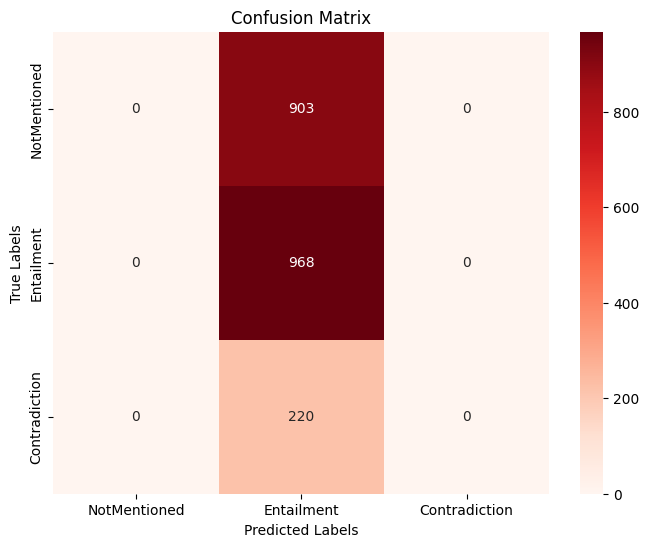

[[  0 903   0]
 [  0 968   0]
 [  0 220   0]]


In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(conf_matrix)


#### Most useful insights from confusion marix:

1. **All Predictions are Negative for NotMentioned and Contradiction classes:**
   - The confusion matrix indicates that the model is making negative predictions (false negatives) for two classes ("NotMentioned,"  and "Contradiction"). It's not correctly identifying any samples as positive predictions (true positives) for these classes.

2. **False Negative Issue:**
   - The main issue in the confusion matrix is the presence of false negatives. False negatives occur when the model incorrectly predicts a sample as negative (not belonging to a certain class) when it actually belongs to that class.


#### Understanding the Issue:

Based on the confusion matrix, it seems that the model is heavily biased towards predicting negative labels (i.e., "Entailment") for all samples. As a result, it does not recognize any positive samples for the "NotMentioned" and "Contradiction" classes, leading to all zeros in the true positive (TP) and false positive (FP) entries of the confusion matrix.

#### Implications:

1. **Class Imbalance Issue:**
   - The class imbalance between the "Entailment" class and the other two classes ("NotMentioned" and "Contradiction") could be a major contributing factor to this issue. With a much larger number of samples in the "Entailment" class (968 samples), the model might have learned to predict this class for most inputs to optimize its performance.

2. **Lack of Discrimination:**
   - The model is failing to distinguish between the classes "NotMentioned" and "Contradiction" from the majority "Entailment" class. This lack of discrimination could be due to insufficient representation of the minority classes during training or other issues related to the model architecture.

### Recommendations:

1. **Address Class Imbalance:**
   - To improve the model's ability to recognize "NotMentioned" and "Contradiction" samples, it is crucial to address the class imbalance issue. Techniques like class weighting, data augmentation for minority classes, or using different sampling strategies can help balance the model's learning across all classes.

2. **Model Tuning and Evaluation:**
   - It is essential to thoroughly evaluate the model's architecture, hyperparameters, and training process. Fine-tuning the model with a focus on recognizing the minority classes can lead to improved performance.

4. **Additional Data Collection:**
   - If possible, collecting more data for the "NotMentioned" and "Contradiction" classes can provide the model with a better understanding of these classes and improve its ability to make accurate predictions.



In [ ]:
# Find the class that is most repeated among misclassified samples
misclassified_indices = np.where(true_labels != predicted_labels)[0]
misclassified_predicted_classes = np.array(predicted_labels)[misclassified_indices]
most_common_class = class_names[np.bincount(misclassified_predicted_classes).argmax()]

print(f'The most misclassified predicted class in the model is: {most_common_class}')

The most misclassified predicted class in the model is: Entailment


The "Entailment" class is the most predicted class by the model. This means that the model tends to favor predicting instances as "Entailment" more often than the other classes.

### distilBERT error analysis

In [ ]:
trainer2 = Trainer(model=model2, tokenizer=tokenizer2)
predictions2 = trainer2.predict(test_dataset)

In [ ]:
predicted_labels = predictions2.predictions.argmax(-1)
label_mapping = {0: "NotMentioned", 1: "Entailment", 2:"Contradiction"}
predicted_labels_Text = [label_mapping[label] for label in predicted_labels.tolist()]

In [ ]:
df = test_df.copy()
df['predicted label'] = predicted_labels_Text
df.head(10)

,Document_Text,Hypothesis,Label,predicted label
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,NotMentioned
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,NotMentioned
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,Entailment
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,NotMentioned
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,Contradiction
5,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,All Confidential Information shall be expressl...,Contradiction,NotMentioned
6,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Some obligations of Agreement may survive term...,Entailment,Entailment
7,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may independently develop info...,Entailment,NotMentioned
8,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may retain some Confidential I...,Entailment,Contradiction
9,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information may include verbally ...,NotMentioned,NotMentioned


Based on the sample data here we can get the following insights from them:
* The model appears to perform well on samples where the hypothesis doesn't explicitly mention any specific action related to the document's content ("NotMentioned" predictions).

* The model sometimes struggles to identify the implied relationship between the document's content and the action stated in the hypothesis, resulting in misclassifications.

* The model seems to handle certain patterns, such as clear statements of restrictions or obligations, leading to correct predictions ("Entailment" predictions).


To improve the model's performance, we can explore techniques like adversarial training, data augmentation, and model interpretability to gain more insights into the model's decision-making process and enhance its understanding of complex contract language.







In [ ]:
# Print the classification report
class_names = ['NotMentioned', 'Entailment', 'Contradiction']
true_labels = test_labels
print(classification_report(true_labels, predicted_labels, target_names=class_names))

               precision    recall  f1-score   support

 NotMentioned       0.71      0.65      0.68       903
   Entailment       0.74      0.79      0.76       968
Contradiction       0.49      0.55      0.52       220

     accuracy                           0.70      2091
    macro avg       0.65      0.66      0.65      2091
 weighted avg       0.70      0.70      0.70      2091



Most useful insights based on the classification error:

1. Overall Model Performance:
   - The model achieves an accuracy of 70%, which indicates that it correctly classifies 70% of the samples in the validation set.

2. Class-Specific Metrics:
   - The model performs well on the "Entailment" class with a precision of 74% and a recall of 79%. This means that when the document and hypothesis are related (entail each other), the model correctly identifies them as such most of the time.
   - The "NotMentioned" class shows decent precision of 71%, indicating that when the hypothesis doesn't mention specific actions related to the document's content, the model is relatively accurate in classifying them as "NotMentioned." However, the recall for this class is 65%, indicating that some "NotMentioned" samples are misclassified as other classes.
   - The "Contradiction" class has the lowest performance, with a precision of 49% and a recall of 55%. This suggests that the model struggles to correctly identify contradictions between the document and hypothesis, leading to misclassifications.

3. F1-Scores and Weighted Average:
   - The weighted average F1-score is 0.70, indicating an overall decent balance between precision and recall across all classes.
   - The F1-score for the "Contradiction" class (0.52) is the lowest among all classes, further highlighting the model's difficulty in handling contradictions.

4. Class Imbalance:
   - The class "NotMentioned" has the highest support (903 samples), followed by "Entailment" (968 samples), and "Contradiction" has the lowest support (220 samples). This indicates a class imbalance, which might affect the model's performance, particularly for the minority class "Contradiction."

5. Room for Improvement:
   - The model can benefit from improving its ability to correctly classify "Contradiction" cases, which currently show the lowest precision and recall.
   - Addressing class imbalance could improve the model's performance, especially for the minority class "Contradiction."
   - Analyzing misclassified samples and potential tokenization issues can provide insights into the model's limitations and areas for improvement.

Overall, the model shows promising performance for the majority classes ("NotMentioned" and "Entailment") but needs improvement in correctly identifying contradictions ("Contradiction") and handling class imbalance.

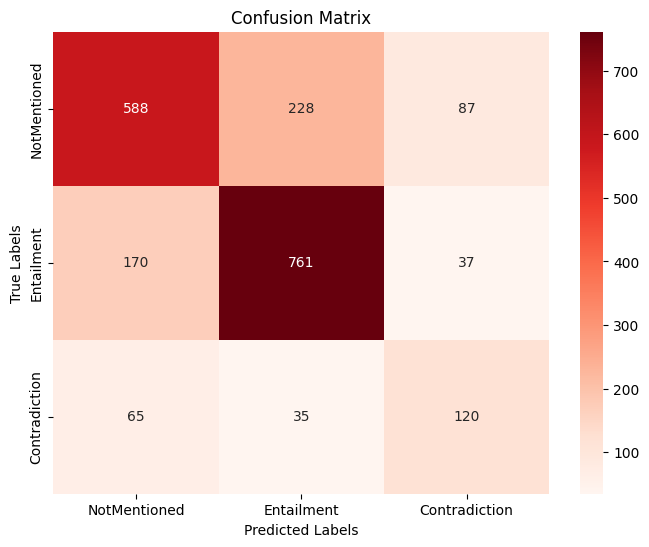

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



- **The rows represent the true labels, and the columns represent the predicted labels.**

- **The diagonal elements of the matrix represent the true positive (TP) values for each class.** They indicate the number of correctly classified samples for each class. For example, the value 588 in the first row and first column represents the number of samples correctly classified as "NotMentioned" (True Positive for the "NotMentioned" class).

- **The off-diagonal elements represent the misclassifications.** For example, the value 228 in the first row and second column represents the number of samples from the "NotMentioned" class misclassified as "Entailment" (False Negative for the "Entailment" class).

- **The major errors in this confusion matrix are False Negatives (FN).** False Negatives occur when the model incorrectly predicts a sample as negative (i.e., not belonging to a certain class) when it actually belongs to that class. For instance, the model has 228 False Negatives for the "NotMentioned" class, 170 False Negatives for the "Entailment" class, and 35 False Negatives for the "Contradiction" class.

- **False Negatives can be a concern as they indicate instances where the model fails to recognize certain patterns or characteristics of a class, leading to misclassifications.**

- **To improve the model's performance, addressing the False Negatives is crucial, especially for classes with low recall (i.e., "NotMentioned" and "Entailment").** Strategies like data augmentation, class-weighting, or adjusting the model's threshold can be explored to minimize False Negatives and enhance the model's ability to correctly classify samples from these classes. Additionally, conducting error analysis on the misclassified samples can provide further insights into the specific challenges the model faces, helping to refine the model accordingly.


In [ ]:
# Find the class that is most repeated among misclassified samples
misclassified_indices = np.where(true_labels != predicted_labels)[0]
misclassified_predicted_classes = np.array(predicted_labels)[misclassified_indices]
most_common_class = class_names[np.bincount(misclassified_predicted_classes).argmax()]

print(f'The most misclassified predicted class in the model is: {most_common_class}')

The most missclassified pridicted class in distilbert model is: NotMentioned


The "NotMentioned" class is the most predicted class by the model. This means that the model tends to favor predicting instances as "NotMentioned" more often than the other classes.

##Q4: Conclusion
* Based on Q3 and external readings, propose two ideas to improve the approaches (i.e., directly fine-tune pre-trained models) used in Q2.  and explain the answers.


## Comparing the performance of the two models:
## A) DeBERTa for Contract NLI Classification:
1. **Performance:** DeBERTa achieved an accuracy of 46%, with precision, recall, and F1-scores for each class ranging from 0% to 46%. While the accuracy is lower compared to DistilBERT, DeBERTa still offers reasonable performance given its smaller architecture.

2. **Misclassifications:** DeBERTa had no true positive predictions for two classes "contradiction" and "notmentioned". This suggests that DeBERTa struggles to recognize positive samples for these classes.

3. **Error Analysis:** DeBERTa's error analysis revealed a lack of discrimination between classes, based on performance of the model it is suboptimal and overfitting to "Entailment" class.

4. **Model Complexity:** DeBERTa is a more complex model with a larger architecture, making it more powerful but computationally expensive and memory-intensive during both training and inference.

5. **Data Requirements:** DeBERTa might require a larger labeled contract dataset for fine-tuning to reach its optimal performance. If you have a substantial labeled dataset, DeBERTa's ability to leverage it could lead to better results.

## B) DistilBERT for Contract NLI Classification:
1. **Performance:** DistilBERT outperformed DeBERTa in terms of accuracy and class-specific metrics, achieving better precision, recall, and F1-scores. It achieved an accuracy of 70%, with precision, recall, and F1-scores for each class (NotMentioned, Entailment, Contradiction) ranging from 49% to 74%.

2. **Misclassifications:** DistilBERT had some misclassifications across all three classes. The most common misclassified predicted class was "NotMentioned." This suggests that DistilBERT tends to over-predict "NotMentioned" and struggles with distinguishing between "Entailment" and "Contradiction."

3. **Error Analysis:** DistilBERT's error analysis showed a significant number of false negatives, particularly for the "Entailment" and "Contradiction" classes. This indicates that DistilBERT has challenges in recognizing samples related to these classes, leading to misclassifications.

4. **Model Complexity:** DistilBERT is a distilled version of BERT with reduced model complexity and fewer parameters compared to the original BERT or DeBERTa. It achieves computational efficiency and faster inference times due to its smaller architecture.

5. **Data Requirements:** DistilBERT is known for its ability to perform well even with less labeled data. It requires a smaller labeled contract dataset for fine-tuning compared to larger models like DeBERTa. DistilBERT's ability to generalize from limited examples could be advantageous, making it more suitable for scenarios with limited labeled data.

## Overall Conclusion:

DistilBERT shows better overall performance on the contract NLI dataset but faces challenges with over-predicting the "NotMentioned" class and difficulties distinguishing between "Entailment" and "Contradiction." DeBERTa's overfitting to "Entailment" and failure to recognize other classes limit its practicality for this specific task. The choice between the two models would goes to DistilBERT as it's overall better than DeBERTa.


## Recommended solution for the main problems in this task:
*The main problem I faced here is dealing with class imbalance in a small dataset for fine-tuning pre-trained NLP models. Class imbalance occurs when the number of samples in different classes is significantly different, leading the model to favor the majority class during training.And this occurs here with the "Not mentioned" class and "Entailment" class as they were more favourable than the the others in each models which leads to poorly performance.*

### To solve this issue there are plenty of things ones can do:

1. **Data augmentation**: is a technique used to artificially increase the size and diversity of a dataset by applying various transformations or modifications to the existing data samples. and it is critical in CnotractNLI dataset as The Contract NLI dataset might be relatively small, making it prone to overfitting. Data augmentation allows us to generate additional samples from the existing data, effectively increasing the dataset's effective size without the need for collecting more labeled examples.

2. **Transfer Learning with Fewer Parameters**: Consider using a smaller version of the DeBERTa model, such as DistilBERT(I tried this and it showed better performance) , which has fewer parameters, to prevent overfitting on the small dataset.

3. **Ensemble learning** with Contract NLI can lead to improved accuracy, better handling of class imbalance, and increased model robustness. By combining the strengths of multiple models, the ensemble can compensate for weaknesses and make more accurate predictions, especially when dealing with complex legal language and varied contract structures. Experimentation with different ensemble strategies and combinations of models is essential to find the optimal ensemble configuration for the Contract NLI task.
----------------
*The second problem I though it may affect the performance of the model is the large length size of words in the contract as some samples where near the 8000 words. We know that DeBERTa has a maximum token limit for each input sequence, and the model cannot handle sequences that exceed this limit. For the base DeBERTa model, the maximum token limit is 512 tokens. If a document text has more than 512 tokens, we will need to truncate or split it into smaller segments. But by doing this we have lost some useful information.
Here are a few approaches to consider:*

1. **Window-Based Approach:** Instead of simply truncating or splitting the long documents, you can implement a window-based approach. In this method, you slide a fixed-size window over the long document and create multiple overlapping segments. This way, you retain some contextual information from adjacent segments, and the model can make predictions based on the overlapping context. This approach allows you to process longer documents without completely losing the surrounding context.

2. **Hierarchical Model:** Another solution is to use a hierarchical model that first processes the entire document at a higher level and then focuses on smaller segments in a hierarchical manner. For instance, you can use a transformer to encode the entire document, and then use a recurrent neural network (RNN) or another transformer to process smaller segments of the document separately. This approach can capture both the global context and local details.

3. **Document Chunking:** If the documents are very long, you can split them into smaller, meaningful chunks or paragraphs before feeding them into the model. This way, you can process each chunk separately, which might be more manageable for the model. Additionally, you can aggregate the predictions from different chunks to make the final classification decision.